<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Classification Metrics II

_Authors: Matt Brems, Dave Yerrington, Noelle Brown, Jeff Hale_

---

### Learning Objectives
- Calculate various classification model evaluation metrics.
- Describe the inverse relationship between sensitivity and specificity.
- Understand what the ROC shows and interpret ROC AUC.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics

In [2]:
# Read in data.
df = pd.read_csv('data/Whickham.csv')
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [ ]:
# Check out first five rows.


- `outcome`: Whether someone is alive or dead.
- `smoker`: Whether somebody smoked or did not smoke.
- `age`: Age in years.

In [4]:
# Turn outcome to 1 if dead and 0 if alive.
df['outcome'] = df['outcome'].map({'Alive': 0, 'Dead': 1})

In [5]:
# Check the distribution of our outcome variable.
df['outcome'].value_counts(normalize=True)

0    0.719178
1    0.280822
Name: outcome, dtype: float64

In [8]:
# Turn smoker column to 1 if smoker and 0 if non-smoker.
df['smoker'] = df['smoker'].map({'Yes': 1, 'No': 0})

In [9]:
df.groupby('smoker').mean()

,outcome,age
smoker,,
0,0.314208,48.699454
1,0.238832,44.682131


One of the interesting things about this data is the relationship between age and smoking.
- You can read more about it [here](https://www2.stat.duke.edu/courses/Spring08/sta103/whickham.pdf).

In [11]:
# How do we usually account for a relationship
# between two independent variables?
df['age_smoker'] = df['age'] * df['smoker'] # interaction term
df.head()

,outcome,smoker,age,age_smoker
0,0,1,23,23
1,0,1,18,18
2,1,1,71,71
3,0,0,67,0
4,0,0,64,0


In [12]:
# Set up X and y.
features = ['age', 'smoker', 'age_smoker']
X = df[features]
y = df['outcome']

In [13]:
# train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [14]:
df.shape

(1314, 4)

In [15]:
# Instantiate model
logreg = LogisticRegression()

# Fit model.
logreg.fit(X_train, y_train);

<details><summary>In this situation, what term would we use to describe someone who is predicted to be dead but actually is alive? (Remember that alive is coded as 0 and dead is coded as 1.)</summary>

- We **falsely** predict someone to be **positive**.
- This would be a **false positive**.
</details>

<details><summary>In this situation, what is a true negative?</summary>

- We **correctly** predict someone to be **negative**.
- Someone who is predicted to be alive (`0`) and actually is alive (`0`).
</details>

<details><summary>If I want to get a good understanding of how our model will do on new data, should I generate a confusion matrix on our training or testing set? Why?</summary>
    
- Testing set!
- If we generate one on our training set, we're going to overestimate the performance of our model... just like if we calculated MSE on our training set.
</details>

In [16]:
# Generate predictions.
preds = logreg.predict(X_test)

In [19]:
# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

pd.DataFrame(metrics.confusion_matrix(y_test, preds), 
             columns=['pred alive', 'pred dead'],
             index=['actual alive', 'actual dead'])

,pred alive,pred dead
actual alive,219,24
actual dead,28,58


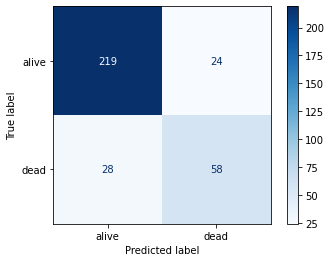

In [18]:
# plot it!
# https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/20_plot_confusion_matrix.ipynb

metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['alive', 'dead']);

### Evaluation Metrics

In [23]:
metrics.confusion_matrix(y_test, preds)

array([[219,  24],
       [ 28,  58]])

In [24]:
metrics.confusion_matrix(y_test, preds).flatten()

array([219,  24,  28,  58])

In [22]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()

# Note that .ravel() will arrange items in a one-dimensional array.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html

**What's the accuracy?**

In [25]:
# by hand
(tp + tn) / (tp + tn + fp + fn)

0.8419452887537994

In [26]:
# from the model
logreg.score(X_test, y_test)

0.8419452887537994

In [27]:
# from sklearn metrics
metrics.accuracy_score(y_test, preds)

0.8419452887537994

**What's the Specificity?**

In [28]:
# What is the test specificity of our model?
# TN / All N
tn / (tn + fp)

0.9012345679012346

**What's the sensitivity (recall)?**

In [29]:
# By hand
# TP / All P
tp / (tp + fn)

0.6744186046511628

In [33]:
# from sklearn
recall = metrics.recall_score(y_test, preds)

**What is the precision?**

In [31]:
# By hand
# Percentage of correct positive predictions
tp / (tp + fp)

0.7073170731707317

In [34]:
# from sklearn
precision = metrics.precision_score(y_test, preds)

### F1 score

The F1 score is the harmonic mean of precision and recall.

If you care about precision and recall roughly the same amount, F1 score is a great metric to use.

Note that even though all the metrics you’ve seen can be followed by the word score F1 always is. 🤷‍♀️

$$
2*\frac{(\text{Precision}*\text{Recall})} {(\text{Precision} + \text{Recall})}
$$

**What is the F1 Score?**

In [40]:
fake_precision = .07
fake_recall = .99
(fake_precision + fake_recall) / 2

0.53

In [41]:
2 * (fake_precision * fake_recall) / (fake_precision + fake_recall)

0.13075471698113206

In [35]:
# by hand
2 * (precision * recall) / (precision + recall)

0.6904761904761904

In [42]:
# from sklearn
metrics.f1_score(y_test, preds)

0.6904761904761904

## Relationship between Sensitivity and Specificity

In [43]:
# Let's create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': logreg.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
1232,0,0.008320
76,1,0.866669
962,0,0.318439
433,0,0.071331
1110,0,0.013771


/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


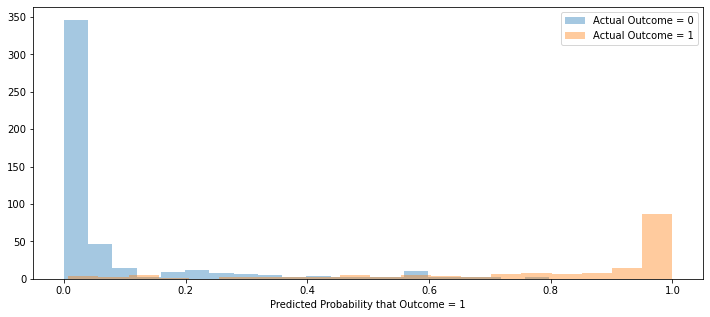

In [44]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

<details><summary>What do you notice about this distribution?</summary>

- Way more blue than orange.
- There's lots of overlap!
</details>

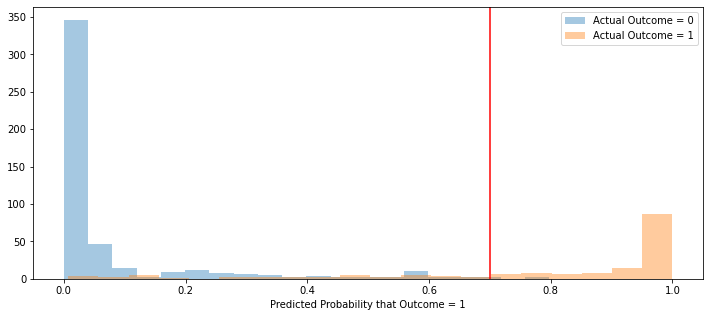

In [47]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(.7, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

<details><summary>Where are my true positives, true negatives, false positives, false negatives in this image?</summary>
    
- True Positive:
    - Items I correctly predict to be positive.
    - The orange bars (actual `1`) that are to the right of the black line (predicted `1`).
- True Negative: 
    - Items I correctly predict to be negative.
    - The blue bars (actual `0`) that are to the left of the black line (predicted `0`).
- False Positive:
    - Items I incorrectly predict to be positive.
    - The blue bars (actual `0`) that are to the right of the black line (predicted `1`).
- False Negative: 
    - Items I incorrectly predict to be negative.
    - The orange bars (actual `1`) that are to the left of the black line (predicted `0`).
</details>

Now, let's adjust our classification threshold to be lower. Instead of using 50% as the cutoff between the positive and negative classes, let's move that threshold down to 10%.
- Any observation with a **predicted probability above 10%** would be **predicted to be in the positive class**.
- Any observation with a **predicted probability below 10%** would be **predicted to be in the negative class**.

<details><summary>When I moved my classification threshold to the left, what happened to sensitivity and specificity?</summary>

- Our number of true negatives decreased and our number of total negatives remains the same.
    - $\text{Specificity} = \frac{TN}{N} \Rightarrow \text{Specificity decreases.}$
- Our number of true positives increased and our number of total positives remains the same.
    - $\text{Sensitivity} = \frac{TP}{P} \Rightarrow \text{Sensitivity increases.}$

</details>

Our goal should be to build a model such that there is **no overlap** between the blue histogram and the orange histogram!
- If there is overlap, we need to recognize the tradeoff between sensitivity and specificity. (As one increases, the other decreases.)
- One measure of how much overlap exists between our distributions is the **area under the ROC curve**.

## Receiver Operating Characteristic (ROC) Curve

Plot the True Positive Rate vs. False Positive Rate for the range of possible decision thresholds and you get the ROC curve!

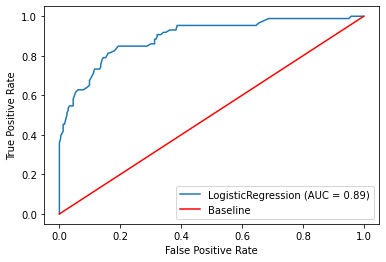

In [50]:
# ROC curve
metrics.plot_roc_curve(logreg, X_test, y_test)
# add worst case scenario line
plt.plot([0,1], [0,1], color='r', label='Baseline')
# add a legend
plt.legend();

### Let's check out [this visualization](http://www.navan.name/roc/)

### ROC AUC

The more area under this blue curve is, the better separated our distributions are.
- Check out this gif ([source](https://twitter.com/DrHughHarvey/status/1104435699095404544)):

![](https://media.giphy.com/media/H1SZ5oRLIuZ1t1c4Di/giphy.gif)

We use the **area under the ROC curve** (abbreviated **ROC AUC** or **AUC ROC**) to quantify the gap between our distributions.

<details><summary>Note: Not to be confused with the ROC AOC.</summary>
<img src="./images/AOC.jpg" alt="AOC" width="400"/>
</details>

In [54]:
probs = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC AUC.
metrics.roc_auc_score(y_test, probs)

0.8949899511915016

### Interpreting ROC AUC
- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)
- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your ROC AUC will now be above 0.5.
    - Example: You have an ROC AUC of 0.2. If you change your predicted 1s to 0s and your predicted 0s to 1s, your ROC AUC will now be 0.8!

We generate one ROC curve per model. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between _sensitivity_ and _specificity_ and understand how well-separated our populations are.

### Changing your prediction threshold

If you want, you could change your prediction threshold to a custom value.

In [65]:
logreg.score(X_test, y_test)

0.8419452887537994

In [68]:
threshold = .7
conservative_preds = (probs >= threshold).astype(int)
metrics.precision_score(y_test, conservative_preds), precision, metrics.accuracy_score(y_test, conservative_preds)

(0.6083333333333333, 0.7073170731707317, 0.817629179331307)

In [67]:
metrics.recall_score(y_test, conservative_preds), recall, metrics.accuracy_score(y_test, conservative_preds)

(0.8488372093023255, 0.6744186046511628, 0.817629179331307)

### Balanced / Unbalanced Classes

Suppose I want to predict the incidence of West Nile Virus (WNV) in Chicago.
- 99.9% of my observations are "no WNV."
- 0.1% of my observations contain "WNV."

If we fit a model and tried to optimize for accuracy, I can predict "no WNV" for every location and have an accuracy score that is really, _really_ good!

<details><summary>Why is this a bad model?</summary>
    
- We'll never predict that a location has West Nile Virus, which is probably going to eventually lead to outbreaks of the disease.
</details>

In classification problems, methods generally perform better when we have roughly equally-sized classes. (i.e. 50% in the positive class and 50% in the negative class for binary classification problems.)

When we do not have each class equally represented, we say we have **unbalanced classes**.

How big of a problem is this? Depends. Realistically, we are probably not going to have a perfect balance of representation from each class. A small amount of imbalance will most likely not matter too much, but a large amount can cause problems. Keep in mind, there are situations where we expect imbalance in our classes (ex. predicting fraud).

#### Methods for Dealing with Unbalanced Classes

- **Weighting observations.** Some models allow the weighting of classes such as linear and logistic regression, Naive Bayes, Random Forests, SVMs, etc. See an example of this [here](https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b).
- **Stratified cross-validation.** If we use $k$-fold cross-validation entirely randomly, we may run into issues where some of our folds have no observations from the minority class. Stratifying is almost always a good idea.
- **Change threshold for classification.** By adjusting our classification threshold, we might find a better fit for our particular use-case.
- **Bias correction.** Gary King wrote a [whitepaper](https://gking.harvard.edu/files/gking/files/0s.pdf) on this topic. This is a rigorous approach and while provide good results it's a bit of work.
- **Create synthetic data of minority class.**
- **Oversample minority class.**
- **Undersample majority class.**
- **Combine oversampling majority and undersampling minority classes.**
- **Optimize for a specific metric.**
- **Get more data!** Cop-out answer. But great if you can! 😀

## Interview Questions

<details><summary>What is the ROC curve?</summary>
    
- The ROC curve is a plot of the True Positive Rate (sensitivity) vs. the False Positive Rate (1 - specificity) for all possible decision thresholds.
</details>

<details><summary>Let's say you were building a search engine and wanted to build a classification model that would recommend articles based on the search input. What metric would you want to optimize for and why?</summary>
    
- You could make a case for wanting to minimize false positives (stories that weren't relevant), in which case you'd want to optimize for precision.
- You could make a case for wanting to minimize false negatives (not passing along possibly useful content), in which case you'd want to optimize for recall. 
- Alumni Comment: "The interviewer seemed more interested in seeing if I knew what the metrics were and explaining what priorities would lead me to optimize for one over the other."
</details>

More interview practice questions on these topics [here](https://kiwidamien.github.io/interview-practice-with-precision-and-recall.html)!